# Bu Tweet Hangi Politik Lidere Ait?

Takvimler ≈üu an 27 Temmuz 2020'yi g√∂stermekte. √úlkece atlattƒ±ƒüƒ±mƒ±z son se√ßim 31 Mart 2019 tarihinde idi. O tarihten bu yana (se√ßim g√ºn√º hari√ß), T√ºrkiye siyasi partilerinden Ak Parti Genel Ba≈ükanƒ± ve T√ºrkiye Cumhurba≈ükanƒ± Recep Tayyip Erdoƒüan ile Cumhuriyet√ßi Halk Partisi Genel Ba≈ükanƒ± Kemal Kƒ±lƒ±√ßdaroƒülu tarafƒ±ndan atƒ±lmƒ±≈ü olan herkese a√ßƒ±k Tweet'leri twint mod√ºl√ºn√º kullanarak scrapeledim. Mod√ºl hakkƒ±nda daha fazla bilgi i√ßin [buraya](https://github.com/twintproject/twint/wiki) tƒ±klayabilirsiniz. Scraping scriptimi (get_tweets.py) bu repoda bulabilirsiniz.

#### √ñzetle, bu projede makine √∂ƒürenimi yoluyla Tweetlerin kim tarafƒ±ndan payla≈üƒ±ldƒ±ƒüƒ±nƒ± tahmin eden bir sƒ±nƒ±flandƒ±rƒ±cƒ± yapacaƒüƒ±z. Daha detaylƒ± bilgiyi devam eden ba≈ülƒ±klarda ve a√ßƒ±klamalarda sunacaƒüƒ±m.

Elimizdeki veri metin verisi, her iki partinin genel ba≈ükanƒ±nƒ±n ≈üu ana kadar atmƒ±≈ü olduklarƒ± Tweetlere dair bilgiler i√ßermekte.

Verilerin yapƒ±landƒ±rmasƒ± ≈üu ≈üekilde:
* id: Tweetlerin √∂zg√ºn kimlik numaralarƒ±
* created_at: Tweetlerin atƒ±lma zamanƒ±
* username: Tweet sahibinin kullanƒ±cƒ± ismi
* tweet: Tweet i√ßeriƒüi (metin)
* mentions: Etiketlenen Twitter kullanƒ±cƒ±larƒ±nƒ±n kullanƒ±cƒ± isimleri
* likes_count: Tweet'in aldƒ±ƒüƒ± like sayƒ±sƒ±
* retweet: Tweet Retweet mi deƒüil mi? (Boolean)
* hashtags: Kullanƒ±lan etiketlerin listesi

√ñnce kullanacaƒüƒ±mƒ±z mod√ºlleri ve elimizdeki verileri i√ße aktararak ba≈ülayalƒ±m:

# 1. Verileri ƒ∞√ße Aktarma ve Ke≈üfetme

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
rte_tweetleri = pd.read_csv("RTErdogan.csv")
kk_tweetleri = pd.read_csv("kilicdarogluk.csv")

#ƒ∞≈ülem kolaylƒ±ƒüƒ± i√ßin verileri tek veri setinde toplayacaƒüƒ±z:
twt = pd.concat([rte_tweetleri, kk_tweetleri])

twt.head()

id     created_at   username  \
0  1287361340080828418  1595765836000  rterdogan   
1  1287043591479664641  1595690078000  rterdogan   
2  1287016078334398464  1595683519000  rterdogan   
3  1286989390846267393  1595677156000  rterdogan   
4  1286603362256003073  1595585120000  rterdogan   

                                               tweet           mentions  \
0  Mill√Æ ƒ∞stihbarat Te≈ükilatƒ± ƒ∞stanbul B√∂lge Ba≈ük...                 []   
1  Eserleriyle tarihe ƒ±≈üƒ±k tutan ‚Äúhocalarƒ±n hocas...                 []   
2  T√ºrkiye Cumhuriyeti Devleti'ni kurulu≈üunun 100...                 []   
3  Amasya √áevre Yolu A√ßƒ±lƒ±≈ü T√∂reni‚Äône canlƒ± baƒüla...                 []   
4  ƒ∞lk cuma namazƒ± @AyasofyaCamii https://twitter...  ['ayasofyacamii']   

   likes_count  retweet hashtags  
0        42189    False       []  
1        50113    False       []  
2        36765    False       []  
3        33986    False       []  
4       121117    False       []

In [3]:
twt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267 entries, 0 to 397
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1267 non-null   int64 
 1   created_at   1267 non-null   int64 
 2   username     1267 non-null   object
 3   tweet        1267 non-null   object
 4   mentions     1267 non-null   object
 5   likes_count  1267 non-null   int64 
 6   retweet      1267 non-null   bool  
 7   hashtags     1267 non-null   object
dtypes: bool(1), int64(3), object(4)
memory usage: 80.4+ KB


G√∂rd√ºƒü√ºm√ºz √ºzere hi√ß eksik verimiz yok. Verilerimizin √ºzerinde √ßalƒ±≈ümaya ba≈ülayabiliriz.

# 2. Verilerin ƒ∞≈ülenmesi

Verilerimizi makine √∂ƒürenimi uygulamadan √∂nce temizleyip i≈ülemek zorundayƒ±z. Buna "created_at" s√ºtunundan ba≈ülayacaƒüƒ±z. Projemize giri≈üte bu s√ºtunun Tweetlerin atƒ±ldƒ±ƒüƒ± zamanƒ± belirttiƒüini s√∂ylemi≈ütik. Oysa s√ºtunumuz ≈üu an integer tipinde. S√ºtunumuzu daha anla≈üƒ±lƒ±r hale getirmek i√ßin datetime tipine √ßevireceƒüiz. Sonrasƒ±nda da "id" s√ºtunumuzu "tweet_id" ≈üeklinde yeniden isimlendireceƒüiz.

In [4]:
twt.created_at = pd.to_datetime(twt.created_at, unit="ms").dt.date #zaman birimi default olarak "ns" ayarlƒ±dƒ±r, bu y√ºzden "ms" olarak belirttik.
twt.created_at.tail()

393    2019-04-12
394    2019-04-09
395    2019-04-08
396    2019-04-03
397    2019-04-02
Name: created_at, dtype: object

In [5]:
twt.rename({"id": "tweet_id"}, axis=1, inplace=True)
twt.head()

tweet_id  created_at   username  \
0  1287361340080828418  2020-07-26  rterdogan   
1  1287043591479664641  2020-07-25  rterdogan   
2  1287016078334398464  2020-07-25  rterdogan   
3  1286989390846267393  2020-07-25  rterdogan   
4  1286603362256003073  2020-07-24  rterdogan   

                                               tweet           mentions  \
0  Mill√Æ ƒ∞stihbarat Te≈ükilatƒ± ƒ∞stanbul B√∂lge Ba≈ük...                 []   
1  Eserleriyle tarihe ƒ±≈üƒ±k tutan ‚Äúhocalarƒ±n hocas...                 []   
2  T√ºrkiye Cumhuriyeti Devleti'ni kurulu≈üunun 100...                 []   
3  Amasya √áevre Yolu A√ßƒ±lƒ±≈ü T√∂reni‚Äône canlƒ± baƒüla...                 []   
4  ƒ∞lk cuma namazƒ± @AyasofyaCamii https://twitter...  ['ayasofyacamii']   

   likes_count  retweet hashtags  
0        42189    False       []  
1        50113    False       []  
2        36765    False       []  
3        33986    False       []  
4       121117    False       []

Verilerimizi ≈üimdilik yeterince temizledik. Elimizdeki veri zaten √ßok sƒ±nƒ±rlƒ± olduƒüu i√ßin ve hi√ß eksik bilgi i√ßermediƒüi i√ßin verilerimizi g√∂rselle≈ütirip analiz edebiliriz.

# 3. Verilerin G√∂rselle≈ütirilmesi ve Analizi

Verilerimizi g√∂rselle≈ütirmeye her iki siyasi fig√ºr√ºn de farklƒ± tarihlerde atmƒ±≈ü olduklarƒ± Tweet sayƒ±larƒ± ile ba≈ülayacaƒüƒ±z. Bunu yapmak i√ßin de Tweetleri atƒ±ldƒ±klarƒ± tarihe ve ait olduklarƒ± politik lidere g√∂re gruplayacaƒüƒ±z.

Text(0, 0.5, 'Tweet Miktarƒ±')

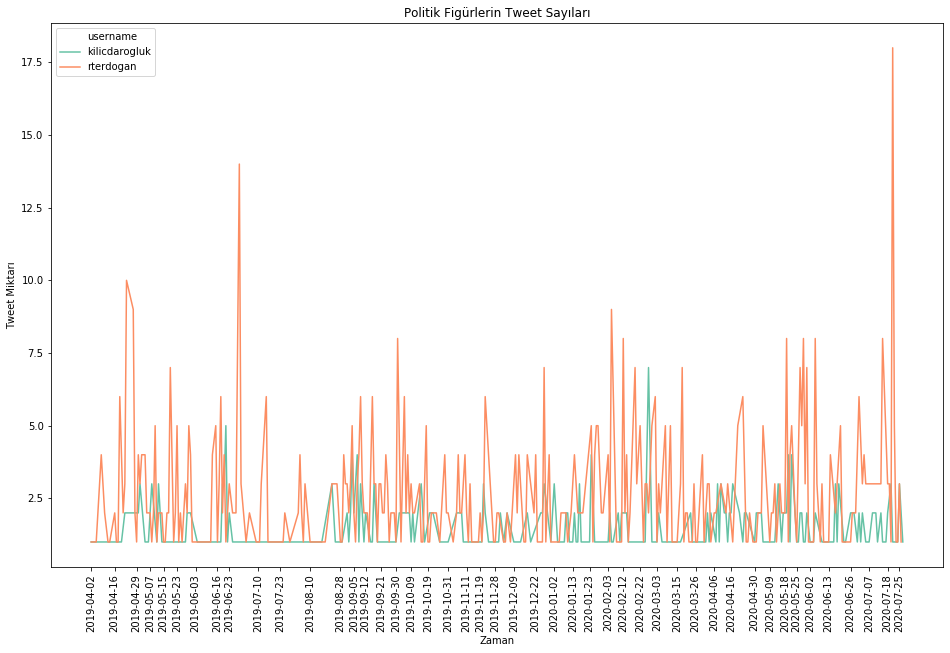

In [6]:
twt_grup = twt[["created_at", "username", "tweet_id"]].groupby(["created_at", "username"]).count().reset_index() #id kƒ±smƒ±nƒ± saya√ß olarak kullanacaƒüƒ±z.

xticks_list = [] 
for index in np.arange(0, 588, 13):
    xticks_list.append(twt_grup.created_at.iloc[index])

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="created_at", y="tweet_id", hue="username", data=twt_grup, palette="Set2", ax=ax)
plt.xticks(xticks_list, rotation=90)
plt.title("Politik Fig√ºrlerin Tweet Sayƒ±larƒ±")
plt.xlabel("Zaman")
plt.ylabel("Tweet Miktarƒ±")

Tabloya baktƒ±ƒüƒ±mƒ±zda g√∂z√ºm√ºze ilk √ßarpan ≈üey Recep Tayyip Erdoƒüan (Turuncu renk) ile Kemal Kƒ±lƒ±√ßdaroƒülu'nun (Ye≈üil renk) Twitter aktivite sƒ±klƒ±ƒüƒ±ndaki fark oluyor. G√∂zlemlenebileceƒüi √ºzere, Kemal Kƒ±lƒ±√ßdaroƒülu'nun Twitter kullanƒ±mƒ± √ßok nadiren g√ºnl√ºk 5 Tweet'ten √∂teye giderken, Recep Tayyip Erdoƒüan g√∂zle g√∂r√ºl√ºr bir farkla sosyal medya kullanƒ±mƒ±nda √ßok daha aktif. Aynƒ± zamanda, Kemal Kƒ±lƒ±√ßdaroƒülu'nun **Tweet attƒ±ƒüƒ± g√ºnlerde** genelde g√ºnl√ºk 3 civarƒ± Tweet atƒ±yor olduƒüu g√∂zlemlebilirken bunu Recep Tayyip Erdoƒüan i√ßin ilk bakƒ±≈üta hesaplamak √ßok m√ºmk√ºn g√∂r√ºnm√ºyor. Recep Tayyip Erdoƒüan'ƒ±n Twitter aktivitesine baktƒ±ƒüƒ±mƒ±zda i√ßinde bulunduƒüumuz haftada (2020, Temmuz sonu) zirve yapmƒ±≈ü bir dalgalanma haline rastlƒ±yoruz. Dilerseniz her iki liderin de 1 Nisan 2019'dan bu yana g√ºnl√ºk ortalama ne kadar tweet atmƒ±≈ü olduklarƒ±nƒ± bir hesaplayalƒ±m:

In [7]:
rte_ortalama_g√ºnl√ºk = twt_grup[twt_grup["username"] == "rterdogan"].tweet_id.mean()
kk_ortalama_g√ºnl√ºk = twt_grup[twt_grup["username"] == "kilicdarogluk"].tweet_id.mean()
print("Ortalama g√ºnl√ºk Tweet sayƒ±sƒ± RTE i√ßin {} iken, KK i√ßin {}.".format(rte_ortalama_g√ºnl√ºk, kk_ortalama_g√ºnl√ºk))

Ortalama g√ºnl√ºk Tweet sayƒ±sƒ± RTE i√ßin 2.641337386018237 iken, KK i√ßin 1.5366795366795367.


G√∂rd√ºƒü√ºm√ºz √ºzere, g√ºnl√ºk atƒ±lan ortalama Tweet sayƒ±sƒ± Recep Tayyip Erdoƒüan i√ßin yakla≈üƒ±k olarak 3 iken Kemal Kƒ±lƒ±√ßdaroƒülu i√ßin 2. Peki, her iki liderin de en √ßok Tweet attƒ±ƒüƒ± tarihlerde neler konu≈üulmu≈ü? Bunu analiz etmek i√ßin Tweet i√ßeriklerine bakacaƒüƒ±z. 

In [8]:
rte_max_gun = list(twt_grup[twt_grup["username"] == "rterdogan"].sort_values("tweet_id", ascending=False).created_at)[0]
kk_max_gun = list(twt_grup[twt_grup["username"] == "kilicdarogluk"].sort_values("tweet_id", ascending=False).created_at)[0]
rte_tweet_icerik = twt[twt["created_at"] == rte_max_gun].tweet
kk_tweet_icerik = twt[twt["created_at"] == kk_max_gun].tweet

for i in rte_tweet_icerik:
    print("RTE: " + i)
print("\n")
for i in kk_tweet_icerik:
    print("KK: " + i)

RTE: Ge√ßmi≈üte en k√º√ß√ºk sarsƒ±ntƒ±da demokrasisiyle, ekonomisiyle, siyasi ve sosyal yapƒ±sƒ±yla adeta yerle yeksan olan bir T√ºrkiye‚Äôden; b√∂lgesel ve k√ºresel her t√ºrl√º sƒ±namayƒ± ba≈üarƒ±yla veren bir T√ºrkiye‚Äôye geldik. pic.twitter.com/NiKcYIs08t
RTE: Cumhurba≈ükanlƒ±ƒüƒ± H√ºk√ºmet Sistemi üáπüá∑ | K√úLT√úR ve TURƒ∞ZM üé•üèñÔ∏è
#Reformƒ∞craatDeƒüi≈üim pic.twitter.com/2iYd6AWbud
RTE: Cumhurba≈ükanlƒ±ƒüƒ± H√ºk√ºmet Sistemi üáπüá∑ | DI≈ûƒ∞≈ûLERƒ∞ üåê
#Reformƒ∞craatDeƒüi≈üim pic.twitter.com/qsLMI5UGyW
RTE: Cumhurba≈ükanlƒ±ƒüƒ± H√ºk√ºmet Sistemi üáπüá∑ | ENERJƒ∞ üí°
#Reformƒ∞craatDeƒüi≈üim pic.twitter.com/xR2sECuZLV
RTE: Cumhurba≈ükanlƒ±ƒüƒ± H√ºk√ºmet Sistemi üáπüá∑ | SANAYƒ∞ ve TEKNOLOJƒ∞ ‚öôÔ∏è
#Reformƒ∞craatDeƒüi≈üim pic.twitter.com/r5ZBqhSRI8
RTE: Cumhurba≈ükanlƒ±ƒüƒ± H√ºk√ºmet Sistemi üáπüá∑ | Tƒ∞CARET üì¶üí≥
#Reformƒ∞craatDeƒüi≈üim pic.twitter.com/ys7ZmPzn15
RTE: Cumhurba≈ükanlƒ±ƒüƒ± H√ºk√ºmet Sistemi üáπüá∑ | HAZƒ∞NE ve MALƒ∞YE üè¶üìà
#Reformƒ∞craatDe

Yukarƒ±da Recep Tayyip Erdoƒüan ve Kemal Kƒ±lƒ±√ßdaroƒülu'nun son se√ßimden bu yana en √ßok Tweet atmƒ±≈ü olduklarƒ± g√ºnlerde attƒ±klarƒ± Tweetleri g√∂r√ºyoruz. Bu verilerden √ßƒ±karƒ±mlarƒ±mƒ±z ≈üunlar olabilir:
* Recep Tayyip Erdoƒüan'ƒ±n Tweetlerinden birini arattƒ±ƒüƒ±mƒ±zda kar≈üƒ±mƒ±za Ba≈ükanlƒ±k Sistemi boyunca √ße≈üitli alanlarda yapƒ±lan icraatler ile ilgili olduƒüunu g√∂r√ºyoruz.
* Kemal Kƒ±lƒ±√ßdaroƒülu'nun Tweetlerine baktƒ±ƒüƒ±mƒ±zda o g√ºn√ºn g√ºndemi hakkƒ±nda daha bilgilendirici olduklarƒ±nƒ± fark etmekteyiz.

≈ûimdi her iki politik fig√ºr√ºn hashtag kullanƒ±mlarƒ±nƒ± inceleyelim.

In [9]:
rte_tags = {}
kk_tags = {}

for tag in rte_tweetleri["hashtags"]:
    if tag not in rte_tags:
        rte_tags[tag] = 1
    else:
        rte_tags[tag] += 1
        
for tag in kk_tweetleri["hashtags"]:
    if tag not in kk_tags:
        kk_tags[tag] = 1
    else:
        kk_tags[tag] += 1

print("RTE En √áok Kullanƒ±lan 5 Hashtag:")
for index, tag in enumerate(sorted(rte_tags.items(), key=lambda x:x[1], reverse=True)):
    if index in range(1, 6):
        print(tag[0] + ": " + str(tag[1]))
        
print("\nKK En √áok Kullanƒ±lan 5 Hashtag:")
for index, tag in enumerate(sorted(kk_tags.items(), key=lambda x:x[1], reverse=True)):
    if index in range(1, 6):
        print(tag[0] + ": " + str(tag[1]))

RTE En √áok Kullanƒ±lan 5 Hashtag:
['#reformiÃácraatdeƒüi≈üim']: 14
['#yenidenyollarad√º≈ümevakti']: 5
['#15temmuz']: 4
['#29ekim']: 3
['#d√ºnya√ßevreg√ºn√º']: 2

KK En √áok Kullanƒ±lan 5 Hashtag:
['#aydƒ±n']: 4
['#1mayƒ±s']: 3
['#lozanbarƒ±≈üantla≈ümasƒ±']: 2
['#erzurumkongresi']: 2
['#s√ºleymandemirel']: 2


Her iki politik fig√ºr√ºn de yaygƒ±n kullandƒ±klarƒ± hashtagleri yukarƒ±da g√∂rebilirsiniz. ≈ûimdi bu politik ki≈üiliklerin zamanla aldƒ±klarƒ± like sayƒ±sƒ±nƒ± g√∂rselle≈ütirelim.

Text(0, 0.5, 'Like Miktarƒ±')

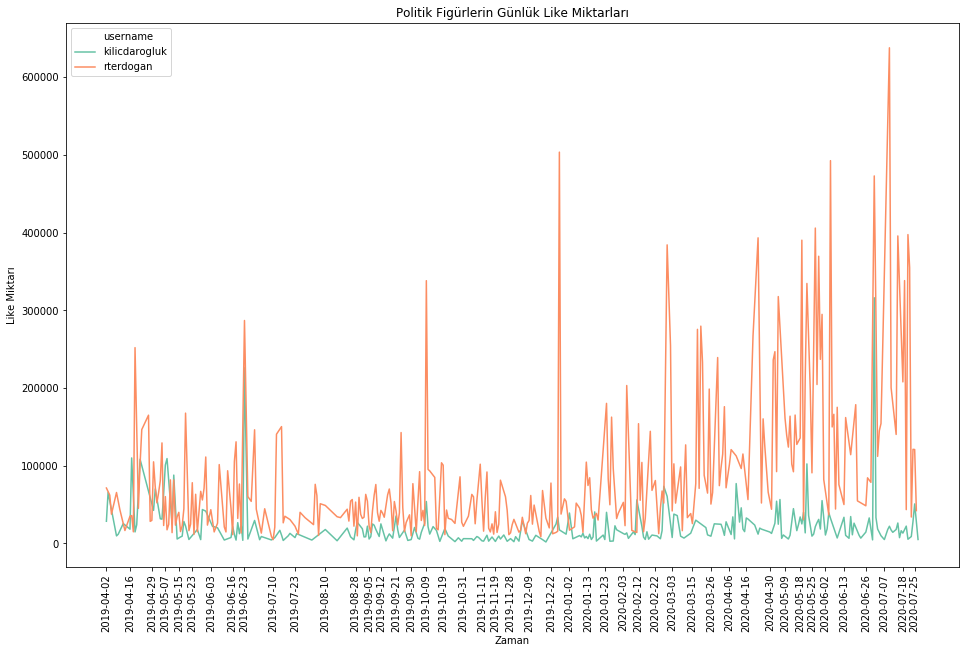

In [10]:
twt_grup_2 = twt[["created_at", "username", "likes_count"]].groupby(["created_at", "username"]).sum().reset_index() #id kƒ±smƒ±nƒ± saya√ß olarak kullanacaƒüƒ±z.

fig1, ax1 = plt.subplots(figsize=(16,10))
sns.lineplot(x="created_at", y="likes_count", hue="username", data=twt_grup_2, palette="Set2", ax=ax1)
_ = plt.xticks(xticks_list, rotation=90)
plt.title("Politik Fig√ºrlerin G√ºnl√ºk Like Miktarlarƒ±")
plt.xlabel("Zaman")
plt.ylabel("Like Miktarƒ±")

Yukarƒ±daki tabloya baktƒ±ƒüƒ±mƒ±zda g√∂z√ºm√ºze √ßarpan ilk ≈üey Recep Tayyip Erdoƒüan'ƒ±n beƒüeni miktarƒ±nƒ±n genel olarak Kemal Kƒ±lƒ±√ßdaroƒülu'nun beƒüenilerinden daha fazla olduƒüu. √ñzellikle 2020 senesine baktƒ±ƒüƒ±mƒ±zda, Recep Tayyip Erdoƒüan tarafƒ±ndan atƒ±lan tweetlerin like sayƒ±larƒ±nƒ±n son zamanlara doƒüru b√ºy√ºk bir artƒ±≈ü g√∂stermi≈ü olduƒüunu farkediyoruz.

Verimizi yeterince incelediƒüimize g√∂re i≈üin makine √∂ƒürenimi olan kƒ±smƒ±na ge√ßebiliriz.

# 4. Terim Aƒüƒ±rlƒ±klandƒ±rma (Feature Weighting)

Bu adƒ±mda Tweetlerde ge√ßen kelimelerin terim frekanslarƒ±nƒ± baz alarak verimizi makine √∂ƒürenimine hazƒ±r bir ≈üekle getireceƒüiz. Bunu yaparken verilerimizi biri makine √∂ƒürenimi esnasƒ±nda, diƒüeri ise hakkƒ±nda sonraki adƒ±mda daha √ßok bilgi edinebileceƒüiniz doƒüruluk testi esnasƒ±nda kullanƒ±lmak √ºzere iki b√∂l√ºme ayƒ±racaƒüƒ±z.

In [11]:
training_data, testing_data = train_test_split(twt, random_state=1) #√ßalƒ±≈ümanƒ±n tekrarlanabilirliƒüi i√ßin seed belirttik.

Y_train = training_data["username"].values
Y_test = testing_data["username"].values

def kelime_sayacƒ±(s√ºtun, training_set, testing_set):

    cv = CountVectorizer(binary=False, max_df=0.95)
    cv.fit_transform(training_data[s√ºtun].values)
    
    train_feature_set = cv.transform(training_data[s√ºtun].values)
    test_feature_set = cv.transform(testing_data[s√ºtun].values)
    
    return train_feature_set, test_feature_set, cv

X_train, X_test, feature_transformer = kelime_sayacƒ±("tweet", training_data, testing_data)

# 5. Lojistik Regresyon

Bu kƒ±sƒ±mda ise hazƒ±rlamƒ±≈ü olduƒüumuz veriler ile √∂nce modelimizi eƒüiteceƒüiz, sonrasƒ±nda test edip Tweet sahibini ne oranda doƒüru tahmin edebiliyor ona bakacaƒüƒ±z. Test i√ßin metrik olarak "Accuracy Score" kullanacaƒüƒ±z. Bu metriƒüin hesaplanmasƒ± ≈üu ≈üekilde yapƒ±lƒ±r:

\begin{equation}
\text{Accuracy Score} = \frac{\text{Doƒüru Tahminlerin Sayƒ±sƒ±}}{\text{Toplam Tahminlerin Sayƒ±sƒ±}}
\end{equation}

In [12]:
classifier = LogisticRegression(solver="newton-cg", C=5, penalty="l2", multi_class="multinomial", max_iter=1000)
model = classifier.fit(X_train, Y_train)

In [13]:
predictions = model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions, normalize=True)
print("Modelimizin doƒüruluƒüu yakla≈üƒ±k olarak {}% oranƒ±ndadƒ±r.".format(round(accuracy, 2) * 100))

Modelimizin doƒüruluƒüu yakla≈üƒ±k olarak 89.0% oranƒ±ndadƒ±r.


# 6. Sonu√ß

### Bu projede 04.01.2019 tarihinden bu yana (27.07.2020) iki pop√ºler politik lider tarafƒ±ndan atƒ±lan Twitter g√∂nderilerini inceledik. Son a≈üamada ise metin sƒ±nƒ±flandƒ±rma i≈ülemlerinde sƒ±k√ßa kullanƒ±lan Lojistik Regresyon modelimizi eƒüittik ve 89% oranƒ±nda doƒüru tahminler elde ettik.